In [15]:
# import SynthGAN_Noise as ran
import model_file
import torch
import module_Noise as module
import numpy as np
import RF_module as RF
import matplotlib.pyplot as plt

In [16]:
runname = 'RFSynthGAN_Noise_gl_0.05/'

In [5]:
device = -1
batch_size=15
images_set = 'synthetic'
in_channels=192

all_image_size = 96
epochs = 968

if in_channels == 3:
    inputtype = 'V1_V4'
if in_channels == 192:
    inputtype = 'all_channels'
    
in_channels=192
netG = model_file.ResblocksDeconv(in_channels, (all_image_size,all_image_size))
netG.load_state_dict(torch.load(f'{runname}/netG_epochs_{epochs}.model', map_location='cpu'))
netG.cpu()
netG.eval()

netD = module.Discriminator()
netD.load_state_dict(torch.load(f'{runname}/netD_epochs_{epochs}.model', map_location='cpu'))
netD.cpu()
netD.eval()

set_t = 'testing'

In [6]:
# --------------------
# R F   G A U S M A P
# --------------------

gaus = module.load_gausdata(size= str(all_image_size))

# --------------------
# I N P U T S
# --------------------
seen_images = module.load_ydata(None, size=str(all_image_size))
seen_images_torch = torch.from_numpy(seen_images)

# --------------------
# I T E R A T O R S
# --------------------
# ------
# Training
# ------
shuffule = False
dot_numbers_train = np.load(f'{set_t}/{set_t}_{images_set[:5]}191final.npy')
iterator = module.make_iterator_unique(dot_numbers_train, set_t, batch_size, shuffle = shuffule)
itera = iter(iterator)

In [7]:

hori_means, verti_means, std_avg = RF.extract_means_std()

confidence_mask = RF.make_confidence_mask(hori_means, verti_means, std_avg, all_image_size)

confidence_mask = torch.from_numpy(confidence_mask.astype('float32'))


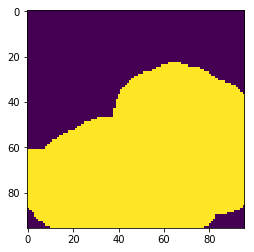

In [8]:
plt.imshow(confidence_mask)

In [9]:
dot_number, img_indices = next(itera)

In [10]:
len(dot_number)

15

In [11]:
# -----
# Inputs
# -----a

gaus_expand_to_batch = gaus.expand([len(img_indices), 191, all_image_size, all_image_size])
weight_images = dot_number[:,:,np.newaxis, np.newaxis].expand([len(img_indices), 191, all_image_size, all_image_size])     

# We want to use the dot number and repeat it (expand to gaus) such that it will have the same shape. 
#Then you multiply with the gaus_exapnd_go_batch!
fixed_noise = torch.randn(len(img_indices), 1, 96, 96)
inputs = module.select_type_inputs(inputtype, gaus_expand_to_batch, weight_images, fixed_noise)
# inputs = inputs.to(cuda0)

# -----
# Targets
# -----
target_batch = seen_images_torch[img_indices]
target_batch = target_batch.transpose(3,1).transpose(2,3)
target_batch *= confidence_mask.expand_as(target_batch)

# ==================================================================
# D I S C R I M I N A T O R| testing
# ==================================================================
# -------------------------
# TEST discr. on REAL img
# -------------------------
b_size = target_batch.size(0)

outputDreal = netD(target_batch).view(-1)

# -------------------------
# TEST discr. on FAKE img
# -------------------------
# ------------------------------------------------------------------
# a First forward pass through the generator
# ------------------------------------------------------------------
outputGfake = netG(inputs) 
outputGfake *= confidence_mask.expand_as(outputGfake)
outputDfake = netD(outputGfake.detach()).view(-1)


# ==================================================================
# G E N E R A T O R| testing
# ==================================================================
# ------------------------------------------------------------------
# TESTING generator: how does image look like
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# a Second forward pass through the generator
# ------------------------------------------------------------------
outputGfake = netG(inputs) 
outputGfake *= confidence_mask.expand_as(outputGfake)

img=seen_images_torch[img_indices]


DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


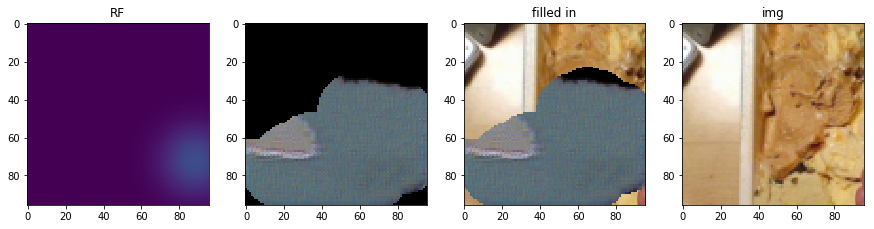

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


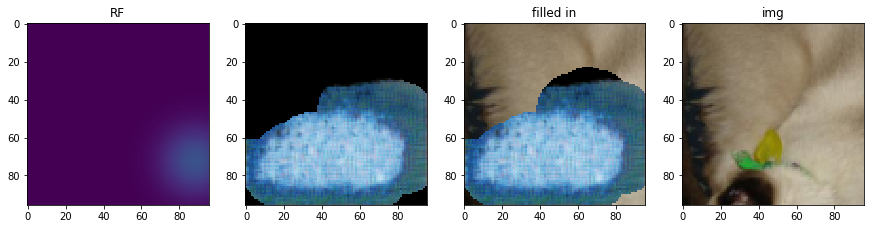

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


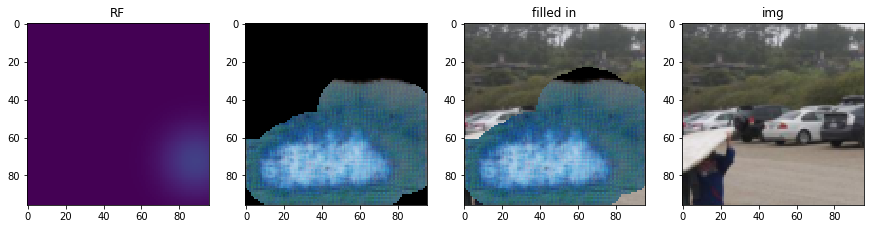

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


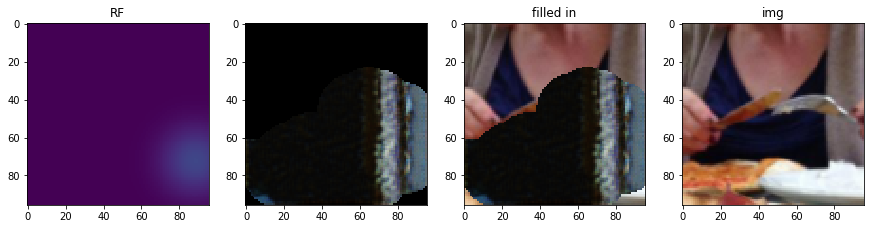

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


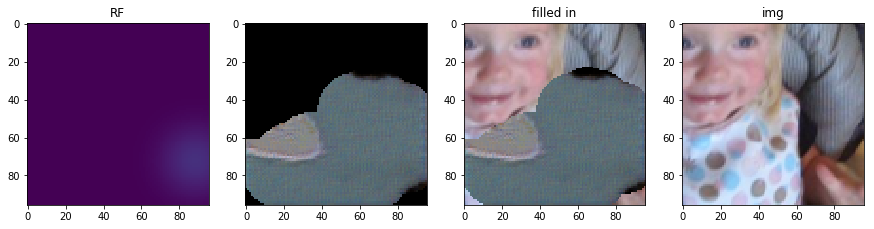

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


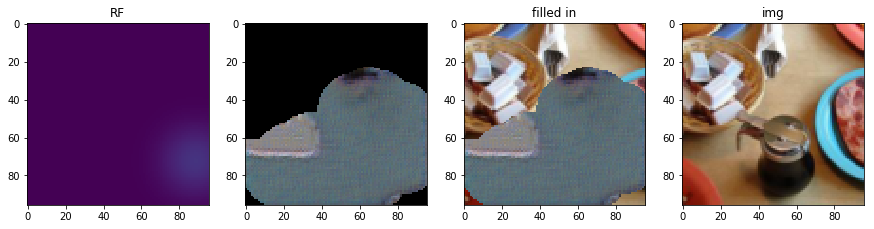

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


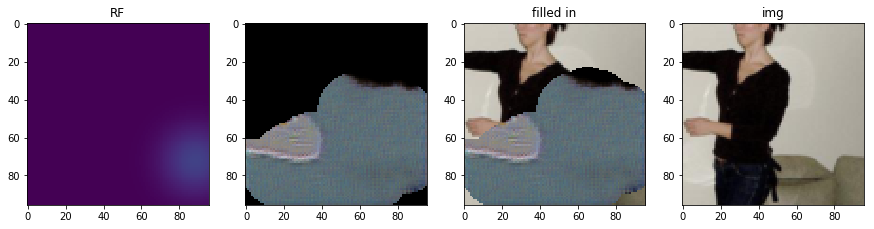

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


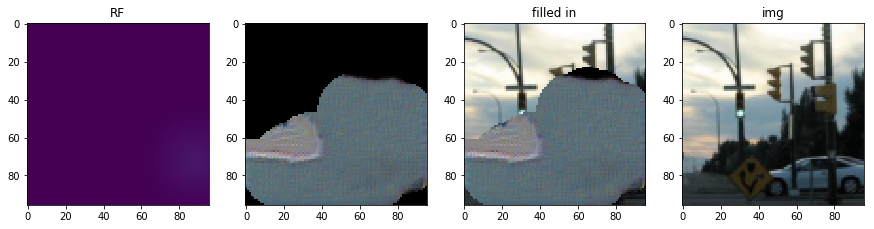

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


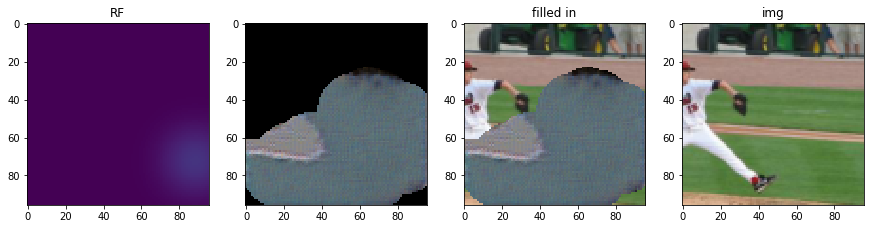

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


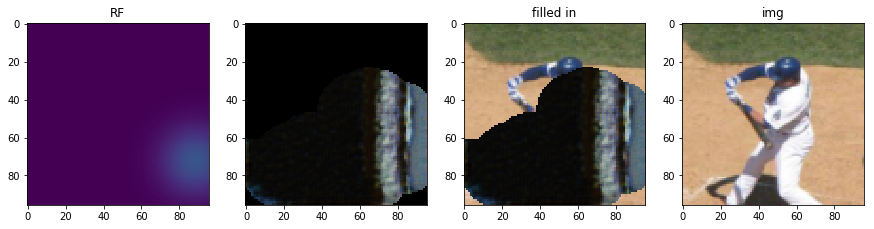

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


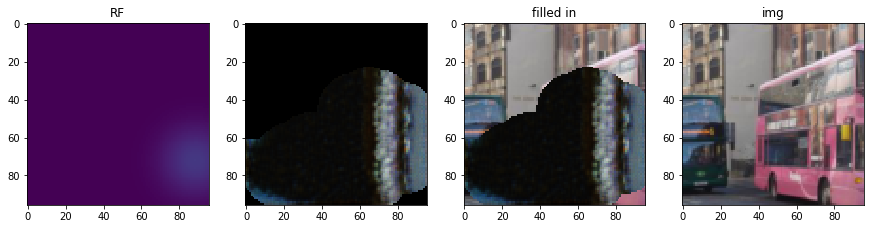

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


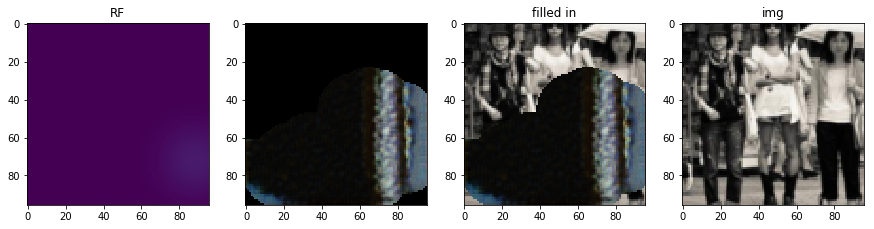

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


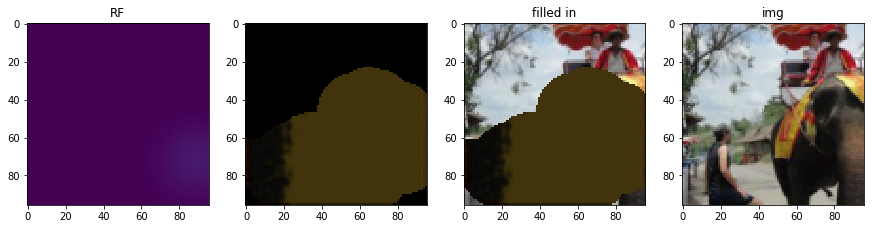

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


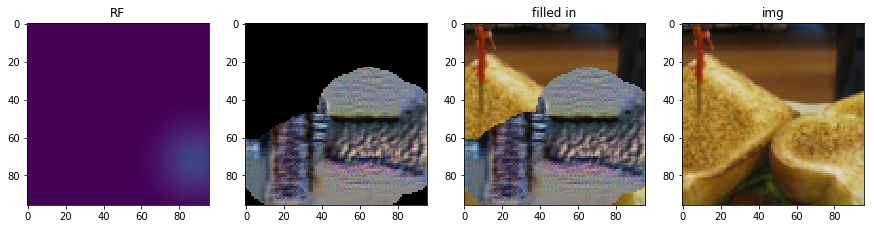

DiscrimFake tensor(0.0165, grad_fn=<SelectBackward>)


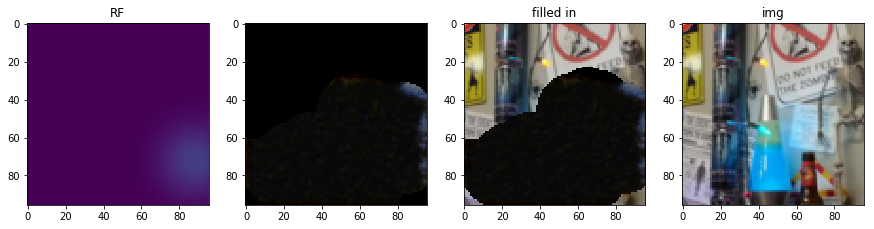

In [12]:


for b in range(batch_size):
    n_plots = 4
    electrode = 100
    y = outputGfake[b].detach().numpy().transpose(1,2,0)
    t = target_batch[b].numpy().transpose(1,2,0)
    filled = (img[b] - t)+y
    
    
    plt.figure(figsize=(15,15))
    print('DiscrimFake', outputDfake[0]) 
    plt.subplot(1,n_plots,1)
    plt.imshow(inputs[b][electrode].detach().numpy(), vmin=inputs[:, :-1].min(), vmax=inputs[:, :-1].max())
    plt.title('RF')
    
    plt.subplot(1,n_plots,2)
    plt.imshow(outputGfake[b].detach().numpy().transpose(1,2,0))
    
#     plt.subplot(1,n_plots,3)
#     plt.imshow(target_batch[b].detach().numpy().transpose(1,2,0))    
    
    plt.subplot(1,n_plots,3)
    plt.imshow(filled, cmap = 'cividis')
    plt.title('filled in')
   
    plt.subplot(1,n_plots,4)
    plt.imshow(img[b])
    plt.title('img')
    
    plt.show()

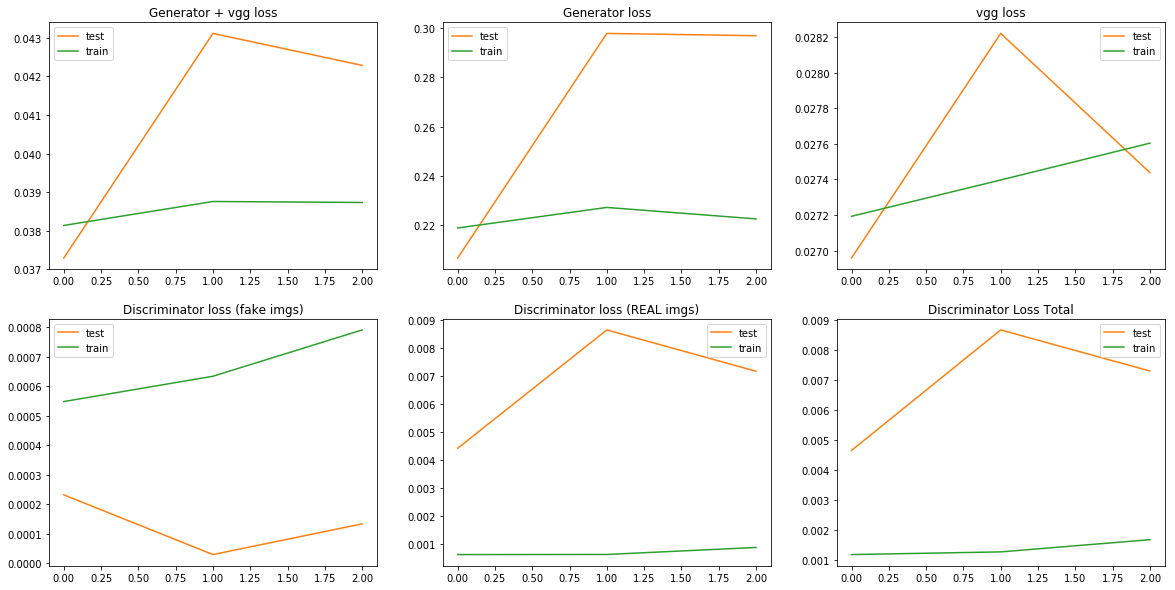

In [14]:
plot_from = 0
n_cols = 3
n_rows = 2
# ======================================
# L O S S E S
# ======================================
# -------------
# T e s t i n g
# -------------
G_vgg_loss_test =  np.load(f'{runname}/G_vgg_loss_test.npy')[plot_from:]
Gloss_test = np.load(f'{runname}/Gloss_test.npy')[plot_from:]
vgg_loss_test = np.load(f'{runname}/vggloss_test.npy')[plot_from:]

Dloss_fake_test = np.load(f'{runname}/Dloss_fake_test.npy')[plot_from:]
Dloss_real_test = np.load(f'{runname}/Dloss_real_test.npy')[plot_from:]
Dloss_test = np.load(f'{runname}/Dloss_test.npy')[plot_from:]

# -------------
# T r a i n i n g
# -------------
G_vgg_loss_train =  np.load(f'{runname}/G_vgg_loss_train.npy')[plot_from:]
Gloss_train = np.load(f'{runname}/Gloss_train.npy')[plot_from:]
vgg_loss_train = np.load(f'{runname}/vggloss_train.npy')[plot_from:]

Dloss_fake_train = np.load(f'{runname}/Dloss_fake_train.npy')[plot_from:]
Dloss_real_train = np.load(f'{runname}/Dloss_real_train.npy')[plot_from:]
Dloss_train = np.load(f'{runname}/Dloss_train.npy')[plot_from:]


plt.figure(figsize=(20,10))

plt.subplot(n_rows,n_cols,1)
plt.title('Generator + vgg loss')
plt.plot(G_vgg_loss_test, label='test', color = 'C1')
plt.plot(G_vgg_loss_train, label='train', color = 'C2')
plt.legend()

plt.subplot(n_rows,n_cols,2)
plt.title('Generator loss')
plt.plot(Gloss_test, label='test', color = 'C1')
plt.plot(Gloss_train, label='train', color = 'C2')
plt.legend()

plt.subplot(n_rows,n_cols,3)
plt.title('vgg loss')
plt.plot(vgg_loss_test, label='test', color = 'C1')
plt.plot(vgg_loss_train, label='train', color = 'C2')
plt.legend()


plt.subplot(n_rows,n_cols,4)
plt.title('Discriminator loss (fake imgs)')
plt.plot(Dloss_fake_test, label = 'test',  color = 'C1')
plt.plot(Dloss_fake_train, label = 'train',  color = 'C2')
plt.legend()

plt.subplot(n_rows,n_cols,5)
plt.title('Discriminator loss (REAL imgs)')
plt.plot(Dloss_real_test, label = 'test',  color = 'C1')
plt.plot(Dloss_real_train, label = 'train',  color = 'C2')
plt.legend()

plt.subplot(n_rows,n_cols,6)
plt.title('Discriminator Loss Total')
plt.plot(Dloss_test, label = 'test',  color = 'C1')
plt.plot(Dloss_train, label = 'train',  color = 'C2')
plt.legend()
